# Getting the most out of GeoPandas 1.0

After 10 years since the first release, GeoPandas reached version 1.0. This workshop will showcase how to get the most out of the recent enhancements and develop a code ready for 2024 and beyond.

**Martin Fleischmann, Joris van den Bossche**

27/05/2024, Basel

## Setup

Follow the ReadMe to set up the environment correctly. You should have these packages installed:

```
- geopandas 1.0
- pyarrow
- geodatasets
```

## What is GeoPandas?

**Easy, fast and scalable geospatial analysis in Python**

From the docs:

> The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

## Outline

Order to be determined

- [x] dot density mapping (sample)
- [x] union_all
- [x] voronoi and delaunay
- [ ] polygonize and build area
- [ ] force_2d and force_3d
- [ ] dwithin joins
- [ ] sjoin with attribute
- [ ] extract_unique_points
- [ ] frechet_distance and hausdorff_distance
- [ ] segmentize
- [ ] hilbert_distance and sort_values
- [ ] save to parquet with bbox and bbox filtering
- [ ] shared_paths and get_geometry

In [1]:
import geopandas
from matplotlib.colors import ListedColormap

from geodatasets import get_path

## Dot density mapping using `sample_points()`

In [12]:
denver = geopandas.read_file("data/denver.gpkg")
denver

,id,name,population,hispanic,white,black,asian,other,geometry
0,32,Hampden,17547,2505,11750,1963,726,38,"MULTIPOLYGON (((-11673632.22 4816695.934, -116..."
1,3,Baker,4879,1664,2854,144,52,7,"MULTIPOLYGON (((-11687147.854 4826152.527, -11..."
2,70,Washington Park,6905,295,6356,28,119,13,"MULTIPOLYGON (((-11684016.806 4824707.965, -11..."
3,13,Cherry Creek,5589,332,4896,79,168,3,"MULTIPOLYGON (((-11681945.81 4824115.619, -116..."
4,22,Country Club,3001,94,2740,20,77,5,"MULTIPOLYGON (((-11684112.74 4826148.089, -116..."
...,...,...,...,...,...,...,...,...,...
70,77,Whittier,4831,1191,2015,1380,49,11,"MULTIPOLYGON (((-11684067.764 4829783.083, -11..."
71,45,Montbello,30348,17855,2478,8605,508,43,"MULTIPOLYGON (((-11667384.473 4832985.484, -11..."
72,44,Marston,11132,1981,8201,103,591,9,"MULTIPOLYGON (((-11695790.546 4810660.229, -11..."
73,27,Fort Logan,8532,2340,5413,157,435,16,"MULTIPOLYGON (((-11692399.886 4815684.467, -11..."


Single layer

In [70]:
white = denver.sample_points(denver.white // 10, rng=42)
white.head()

0    MULTIPOINT ((-11679998.434 4817480.075), (-116...
1    MULTIPOINT ((-11690181.008 4826013.116), (-116...
2    MULTIPOINT ((-11685579.861 4821219.881), (-116...
3    MULTIPOINT ((-11684096.77 4826126.967), (-1168...
4    MULTIPOINT ((-11685523.16 4826223.301), (-1168...
Name: sampled_points, dtype: geometry

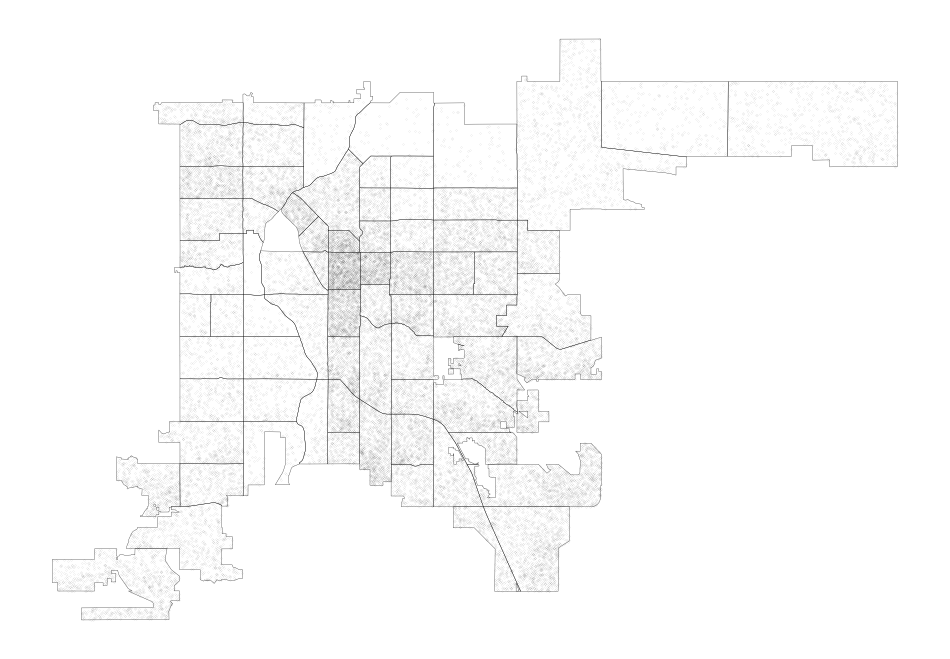

In [71]:
ax = white.plot(color="k", markersize=0.001, figsize=(12, 12))
denver.boundary.plot(ax=ax, color="k", linewidth=0.2)
ax.set_axis_off()

Multiple layers

In [72]:
hispanic = denver.sample_points(denver.hispanic // 10, rng=42)
black = denver.sample_points(denver.black // 10, rng=42)
asian = denver.sample_points(denver.asian // 10, rng=42)

The manual way

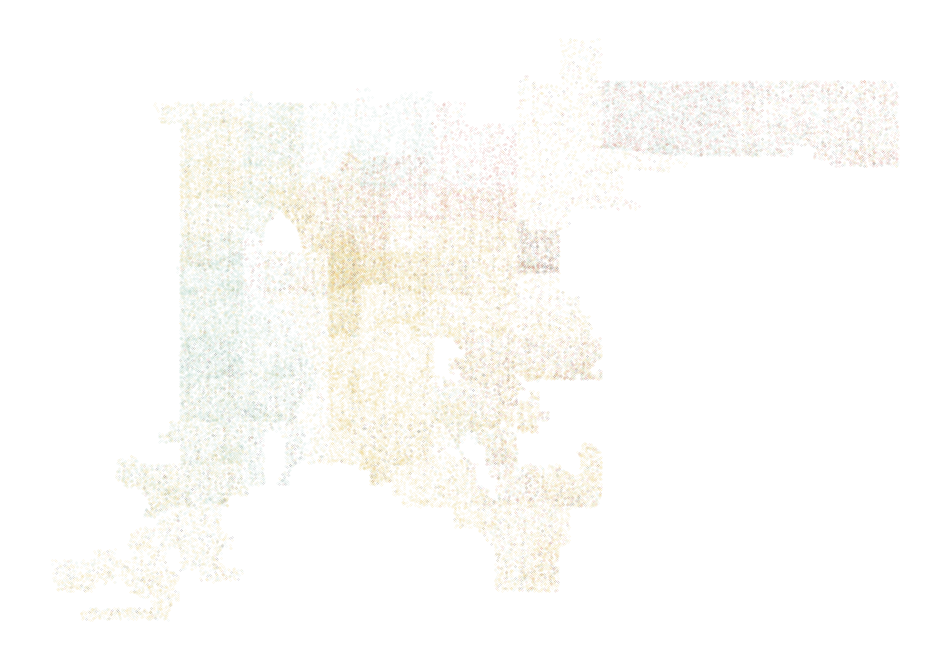

In [73]:
ax = white.plot(color="#F2CF63", markersize=0.005, figsize=(12, 12))
hispanic.plot(color="#ADD9C9", markersize=0.005, ax=ax)
black.plot(color="#D96459", markersize=0.005, ax=ax)
asian.plot(color="#3B2F40", markersize=0.005, ax=ax)
ax.set_axis_off()

As one GeoDataFrame

In [74]:
dot_density = geopandas.GeoDataFrame(
    {"population": ["white", "hispanic", "black", "asian"]},
    geometry=[
        white.union_all(),
        hispanic.union_all(),
        black.union_all(),
        asian.union_all(),
    ],
    crs=denver.crs,
)

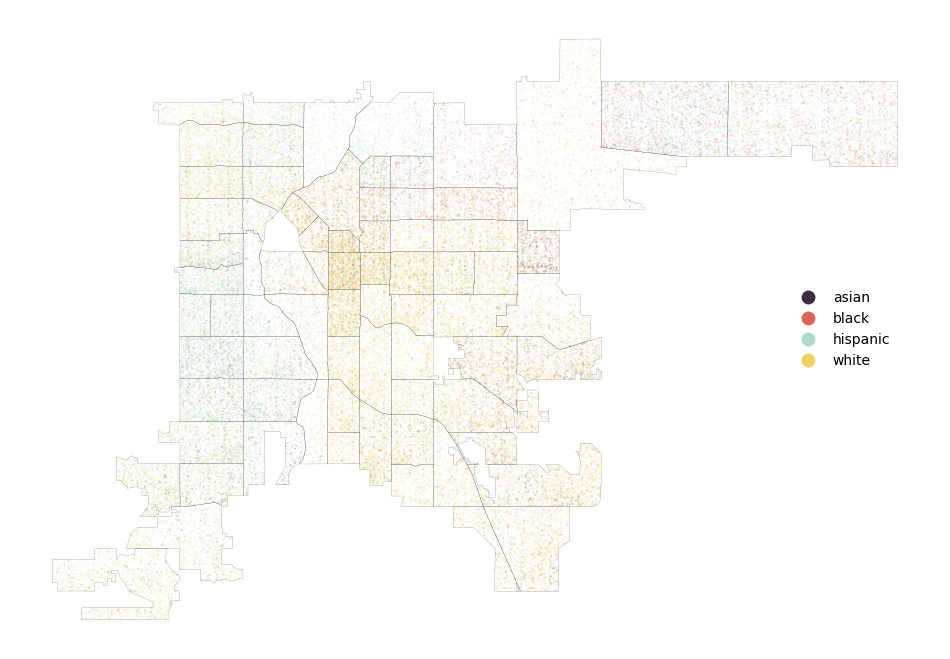

In [111]:
cmap = ListedColormap(["#3B2F40", "#D96459", "#ADD9C9", "#F2CF63"])
ax = dot_density.plot(
    column="population",
    cmap=cmap,
    legend=True,
    markersize=0.005,
    figsize=(12, 12),
    legend_kwds=dict(loc="center right", bbox_to_anchor=(.96, 0.5), frameon=False),
)
denver.boundary.plot(ax=ax, color="k", linewidth=0.1)
ax.set_axis_off()

## Union_all and coverage union

In [116]:
nyc = geopandas.read_file(get_path("geoda nyc education"), columns=["BoroCode"])
nyc

,BoroCode,geometry
0,1,"POLYGON ((989819.296 204093.995, 989701.137 20..."
1,1,"POLYGON ((990340.007 205029.463, 990332.127 20..."
2,1,"POLYGON ((989553.91 209596.796, 989428.664 209..."
3,1,"POLYGON ((984534.75 210565.445, 984410.138 210..."
4,1,"POLYGON ((990440.506 215405.064, 990312.78 215..."
...,...,...
2211,2,"POLYGON ((1006864.49 250068.955, 1006943.704 2..."
2212,2,"POLYGON ((1008387.372 253289.879, 1008369.669 ..."
2213,2,"POLYGON ((1007528.877 251899.748, 1007347.394 ..."
2214,2,"POLYGON ((1007647.656 249141.043, 1007474.333 ..."


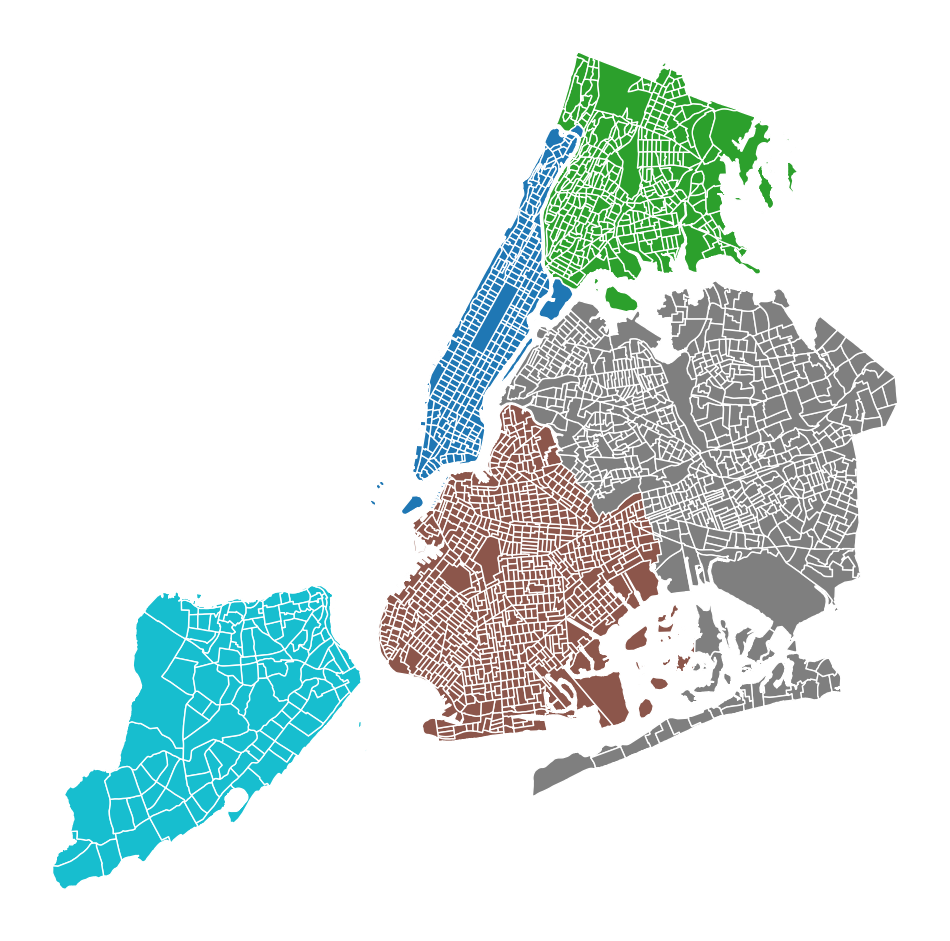

In [106]:
nyc.plot("BoroCode", figsize=(12, 12), edgecolor="w", linewidth=1).set_axis_off()

Doing union of all geometries

In [103]:
%timeit nyc.union_all()
%timeit nyc.union_all(method="coverage")

418 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.6 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Dissolving geomerties to boroughs.

In [117]:
boroughs = nyc.dissolve("BoroCode")
boroughs

,geometry
BoroCode,
1,"MULTIPOLYGON (((977760.694 188491.862, 977755...."
2,"MULTIPOLYGON (((1002999.818 233784.197, 100292..."
3,"MULTIPOLYGON (((983510.117 147633.163, 983491...."
4,"MULTIPOLYGON (((1012286.026 142096.516, 101228..."
5,"MULTIPOLYGON (((922447.395 122462.045, 922431...."


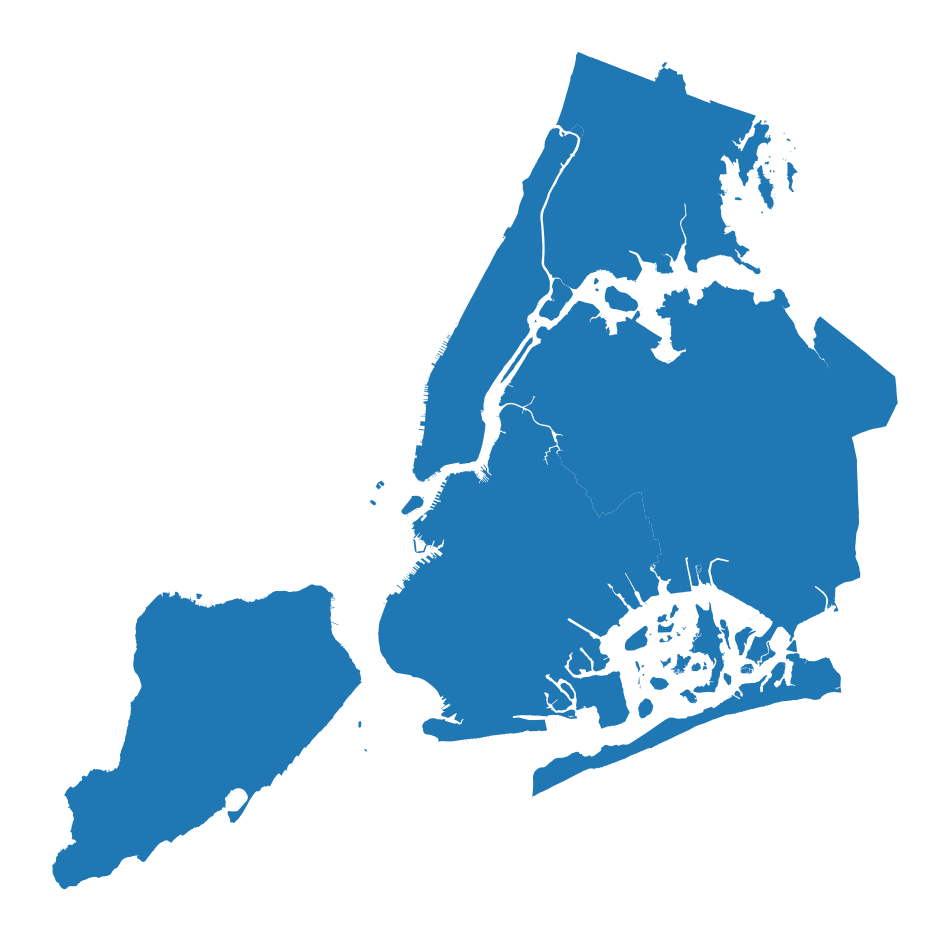

In [107]:
boroughs.plot(figsize=(12, 12)).set_axis_off()

In [105]:
%timeit nyc.dissolve("BoroCode")
%timeit nyc.dissolve("BoroCode", method="coverage")

365 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
24.9 ms ± 506 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Voronoi and Delaunay

In [22]:
groceries = geopandas.read_file(get_path("geoda groceries"))
groceries.head()

,OBJECTID,Ycoord,Xcoord,Status,Address,Chain,Category,geometry
0,16,41.973266,-87.657073,OPEN,"1051 W ARGYLE ST, CHICAGO, IL. 60640",VIET HOA PLAZA,None,MULTIPOINT ((1168268.672 1933554.35))
1,18,41.696367,-87.681315,OPEN,"10800 S WESTERN AVE, CHICAGO, IL. 60643-3226",COUNTY FAIR FOODS,None,MULTIPOINT ((1162302.618 1832900.224))
2,22,41.868634,-87.638638,OPEN,"1101 S CANAL ST, CHICAGO, IL. 60607-4932",WHOLE FOODS MARKET,None,MULTIPOINT ((1173317.042 1895425.426))
3,23,41.877590,-87.654953,OPEN,"1101 W JACKSON BLVD, CHICAGO, IL. 60607-2905",TARGET/SUPER,new,MULTIPOINT ((1168996.475 1898801.406))
4,27,41.737696,-87.625795,OPEN,"112 W 87TH ST, CHICAGO, IL. 60620-1318",FOOD 4 LESS,None,MULTIPOINT ((1176991.989 1847262.423))


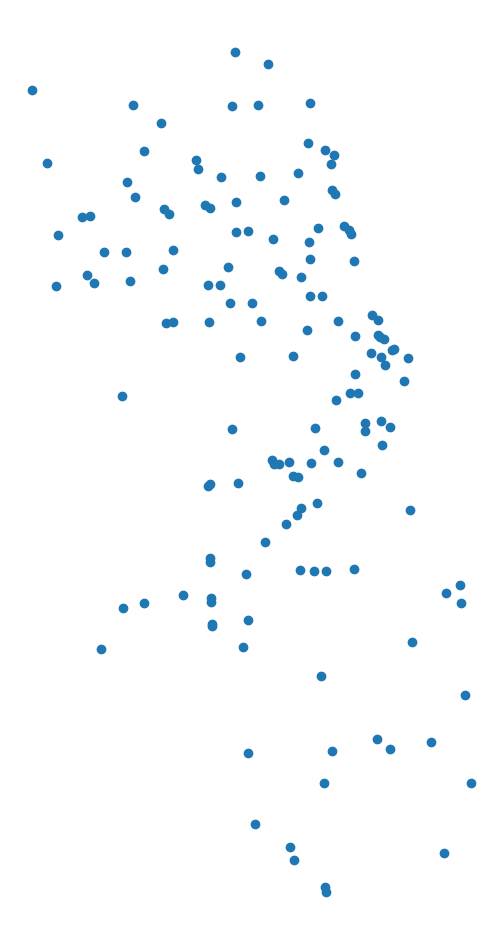

In [3]:
groceries.plot(figsize=(12, 12)).set_axis_off()

In [23]:
voronoi = groceries.voronoi_polygons()
voronoi

0      POLYGON ((1000232.507 2074106.054, 1115459.443...
1      POLYGON ((1133269.833 1936693.104, 1132179.31 ...
2      POLYGON ((1132179.31 1931936.279, 1133269.833 ...
3      POLYGON ((1131860.838 1931676.216, 1132179.31 ...
4      POLYGON ((1000232.507 1914933.059, 1016175.628...
                             ...                        
143    POLYGON ((1312881.31 1873676.388, 1186730.581 ...
144    POLYGON ((1179241.206 1851983.733, 1179407.631...
145    POLYGON ((1312881.31 1867907.848, 1187106.089 ...
146    POLYGON ((1312881.31 1789219.816, 1180766.062 ...
147    POLYGON ((1312881.31 1856617.936, 1189593.359 ...
Length: 148, dtype: geometry

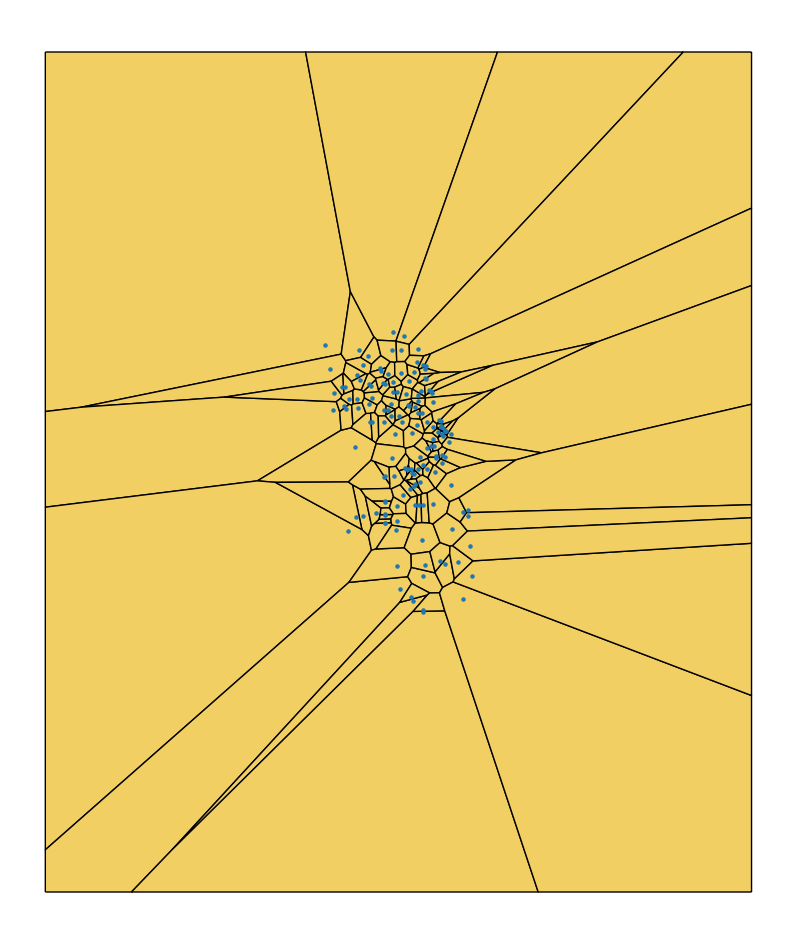

In [24]:
ax = voronoi.plot(color="#F2CF63", figsize=(12, 12), edgecolor="k")
groceries.plot(ax=ax, markersize=5)
ax.set_axis_off()


In [25]:
voronoi_edges = groceries.voronoi_polygons(only_edges=True)
voronoi_edges

0      LINESTRING (1115459.443 2074106.054, 1135272.7...
1      LINESTRING (1135272.749 1968043.026, 1131203.4...
2      LINESTRING (1131203.483 1940354.304, 1016175.6...
3      LINESTRING (1016175.628 1916856.403, 1000232.5...
4      LINESTRING (1133269.833 1936693.104, 1132179.3...
                             ...                        
421    LINESTRING (1312881.31 1873676.388, 1186730.58...
422    LINESTRING (1180527.267 1855547.395, 1189593.3...
423    LINESTRING (1189593.359 1848826.935, 1181315.0...
424    LINESTRING (1312881.31 1867907.848, 1187106.08...
425    LINESTRING (1189593.359 1848826.935, 1312881.3...
Length: 426, dtype: geometry

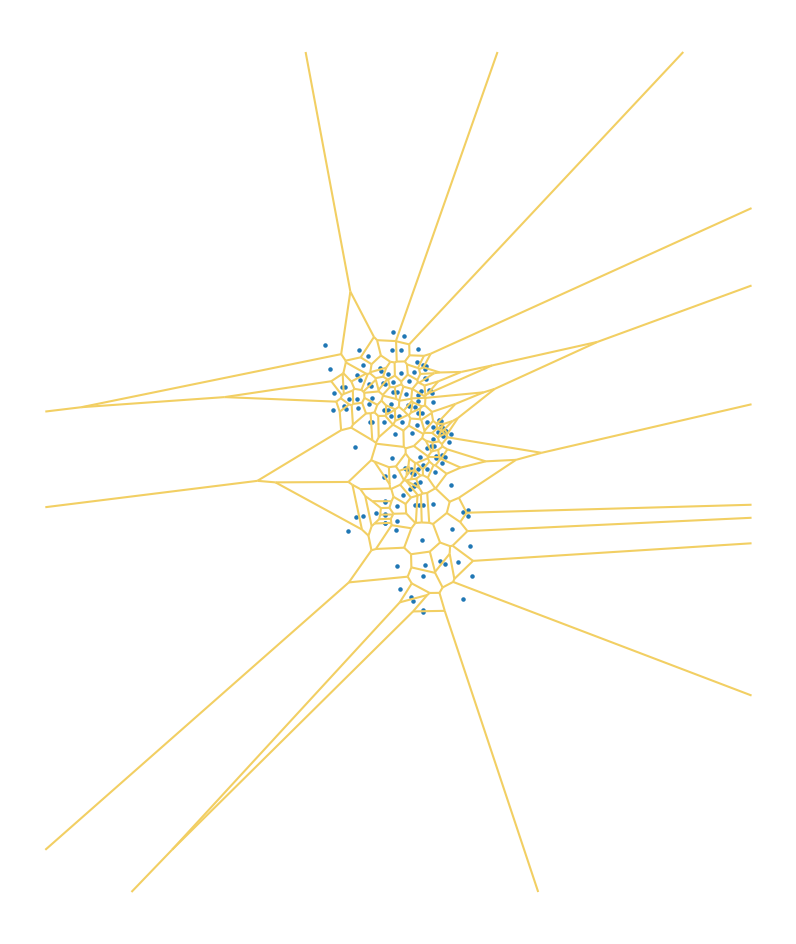

In [26]:
ax = voronoi_edges.plot(color="#F2CF63", figsize=(12, 12))
groceries.plot(ax=ax, markersize=5)
ax.set_axis_off()


In [27]:
delaunay = groceries.delaunay_triangles()
delaunay

0      POLYGON ((1124187.65 1944565.704, 1127678.522 ...
1      POLYGON ((1124187.65 1944565.704, 1126401.425 ...
2      POLYGON ((1124187.65 1944565.704, 1139134.342 ...
3      POLYGON ((1154085.944 1950150.911, 1139134.342...
4      POLYGON ((1154085.944 1950150.911, 1143269.795...
                             ...                        
276    POLYGON ((1159845.951 1889332.781, 1162757.555...
277    POLYGON ((1160691.552 1889319.163, 1162757.555...
278    POLYGON ((1155827.418 1873174.053, 1150416.357...
279    POLYGON ((1167309.465 1842289.996, 1162302.618...
280    POLYGON ((1167501.652 1826876.7, 1162302.618 1...
Length: 281, dtype: geometry

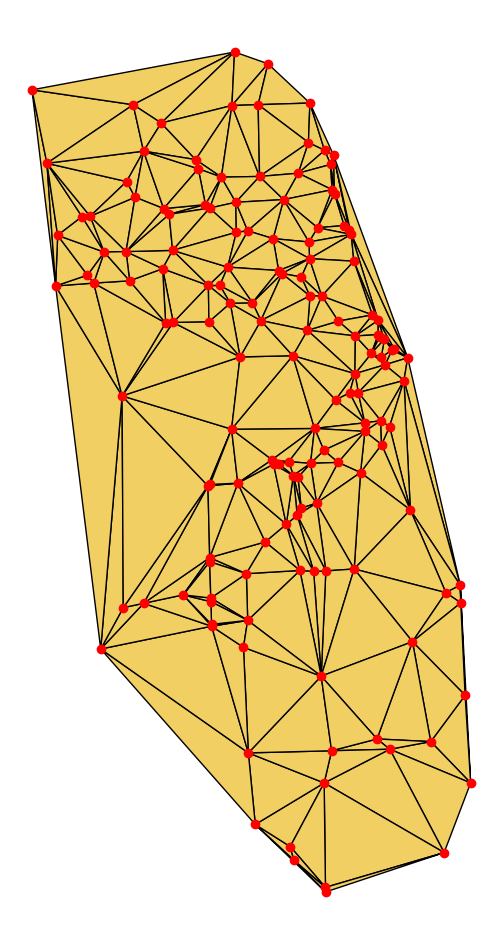

In [18]:
ax = delaunay.plot(color="#F2CF63", figsize=(12, 12), edgecolor="k")
groceries.plot(ax=ax, color="red")
ax.set_axis_off()


In [28]:
delaunay_edges = groceries.delaunay_triangles(only_edges=True)
delaunay_edges

0      LINESTRING (1187396.519 1871470.375, 1188926.1...
1      LINESTRING (1179638.801 1905021.885, 1187396.5...
2      LINESTRING (1168697.03 1934923.414, 1179638.80...
3      LINESTRING (1165206.492 1942615.506, 1168697.0...
4      LINESTRING (1159017.07 1948417.78, 1165206.492...
                             ...                        
423    LINESTRING (1175292.213 1908442.237, 1175480.5...
424    LINESTRING (1174282.979 1905680.012, 1175480.5...
425    LINESTRING (1175480.599 1908055.965, 1176200.6...
426    LINESTRING (1174282.979 1905680.012, 1176200.6...
427    LINESTRING (1162302.618 1832900.224, 1167501.6...
Length: 428, dtype: geometry

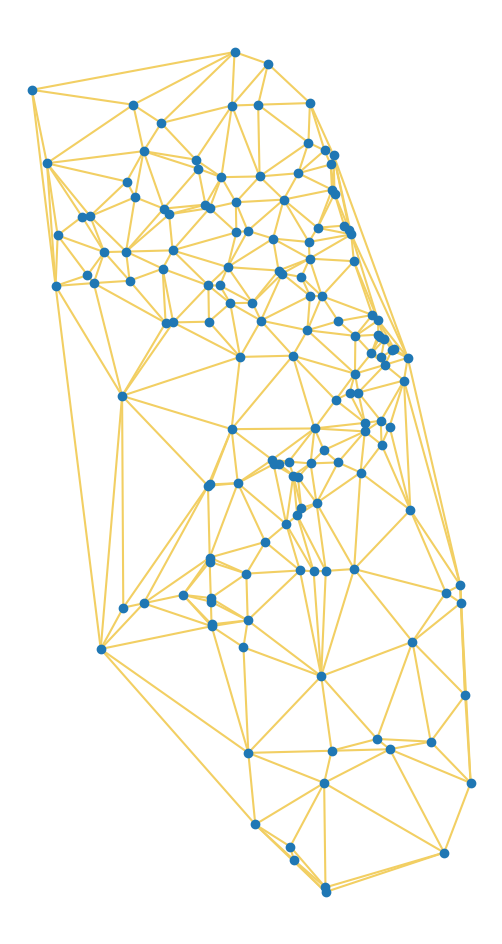

In [29]:
ax = delaunay_edges.plot(color="#F2CF63", figsize=(12, 12), edgecolor="k")
groceries.plot(ax=ax, zorder=2)
ax.set_axis_off()


In [30]:
denver.head()

,id,name,population,hispanic,white,black,asian,other,geometry
0,32,Hampden,17547,2505,11750,1963,726,38,"MULTIPOLYGON (((-11673632.22 4816695.934, -116..."
1,3,Baker,4879,1664,2854,144,52,7,"MULTIPOLYGON (((-11687147.854 4826152.527, -11..."
2,70,Washington Park,6905,295,6356,28,119,13,"MULTIPOLYGON (((-11684016.806 4824707.965, -11..."
3,13,Cherry Creek,5589,332,4896,79,168,3,"MULTIPOLYGON (((-11681945.81 4824115.619, -116..."
4,22,Country Club,3001,94,2740,20,77,5,"MULTIPOLYGON (((-11684112.74 4826148.089, -116..."


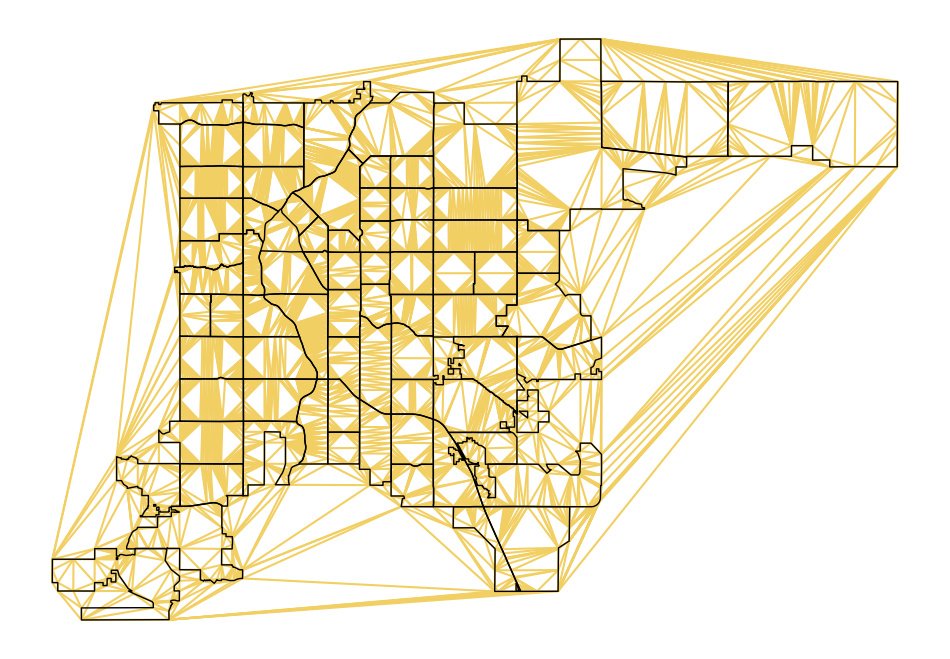

In [21]:
denver_delaunay = denver.delaunay_triangles(only_edges=True)

ax = denver_delaunay.plot(color="#F2CF63", figsize=(12, 12), edgecolor="k")
denver.boundary.plot(ax=ax, color="k", linewidth=1)
ax.set_axis_off()
